# <center>CPE378 Machine Learning</center>
# <center>Lab Lecture 07 - Convolutional Neural Network (CNN)</center>
## <center>Training Deep Convolutional Neural Network</center>
--- 

# Member
- Piyatida Meesatean, 62070505210
- Ornrakorn Mekchaiporn, 62070505238


## Lab Instruction 

In this lab, you will learn to train a deep convolutional neural network using Keras library with Tensorflow backend. We will use  Cat vs Dog dataset.

See https://www.kaggle.com/c/dogs-vs-cats/data


### Your Turn! Dog or Cat Application 

Now, it time to put everything together and develop and Cat vs Dog classifier model. Assume that you and your company want to get more attraction on your product by launching a new product that can classify whether it is a dog or a cat. You have decide that you want a precision more than 90 - 95% in order to launch to product.

You have a cat and dog dataset contain total of 25000 images, 12500 for cat and other half for a dog.

After successfully develop this model, you can try to play with it to see how it perform. (You can upload your selfies image to see you are a dog or a cat)

Some note before start a project:
1. You have to load a data into a project using any method 
**suggest**
   

```
 !wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
 !unzip -qq Cat_Dog_data.zip
```


2. You have to plan on how you will split a data. (or no need for suggest method)
3. You have to preprocess your data before feed into a network. For example, cropping, padding, etc.
4. You can come up with any model or use pre-train model. It depend on you!

You have two week for this project so that you can compete with your competitor app! Now, create a new Jupyter notebook and start building a model!

---
## **Lab นี้ประกอบไปด้วย 📖**
**เนื้อหาหลัก:**
1. Load dataset
2. Data exploration
3. Preprocess data
4. Build convolutional neural network
5. Train Model
6. Evaluate Model 
7. Conclusion

และ **Challenge: ลองใส่หน้าตัวเองไปแล้วให้ model ทำนายดู**



---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks
from keras import backend as K
from keras.preprocessing import image
from keras.datasets import fashion_mnist
#from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import np_utils
from keras.layers.convolutional import  MaxPooling2D
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Flatten, Dense,BatchNormalization,Dropout,Input
from keras.models import Sequential, Model

import pandas as pd
from skimage.io import imread
from skimage.io import imshow
import os

In [3]:
# %load _utils
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras import backend as K

# Test
def print_hello():
    print('Hello')

# define a function to plot the result from training step
def show_result(history): 
    
    # Print the result from the last epoch
    print('Last train accuracy: %s'%history.history['acc'][-1])
    print('Last validation accuracy: %s'%history.history['val_acc'][-1])
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    
    epochs = range(1, len(loss) + 1)   
    
    # Define a subplot 
    fig, axs = plt.subplots(1,2,figsize=(15,4))
    
    # Plot loss
    loss_plot = axs[0]
    
    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()
    
    # Plot accuracy
    acc_plot = axs[1]
    
    acc_plot.plot(epochs, acc, 'c--', label='Training acc')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation acc')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()

# Define an evaluation function to print the evaluation result
def evaluation_report(model,features,labels):
    
    # Calculate result
    result = model.evaluate(features,labels,verbose=False)
    
    # Predict and convert into a class
    pred_class = model.predict(features).argmax(axis=1)
    labels = labels.argmax(axis=1)
    # Show report
    print(confusion_matrix(labels,pred_class))
    print(classification_report(labels,pred_class))
    print("Loss: %s Accuracy: %s" %(result[0],result[1]))
    
    return pred_class


# Show a subplot of the incorrect predict data
def show_false_prediction(predict, feature, label, img_size=28, channel=1):

    false_pred = feature[(predict != label).tolist()]
    actual_label = label[(predict != label).tolist()]
    false_label = predict[(predict != label).tolist()]
    if channel == 3:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size,channel)
    elif channel == 1:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size)
    else:
        raise ValueError('Must be RGB or gray scale image')
    
    print(false_pred.shape)

    fig, ax = plt.subplots(3,10,figsize=(15,6))
    fig.suptitle('The incorrect prediction')

    for i in range(3):
        for j in range(10):
            ax[i,j].imshow(false_pred[j + i*10],cmap='gray')
            ax[i,j].set_title('Pred %s Act %s'%(false_label[j + i*10],actual_label[j + i*10]))
            
# Show activation value of each layer
def show_layer_activation(activation, model,num_layer,num_row=16):
    layer_names = []
    for layer in model.layers[:num_layer]:
        layer_names.append(layer.name)

    images_per_row = num_row
    for layer_name, layer_activation in zip(layer_names,activation):
        n_features = layer_activation.shape[-1]

        size = layer_activation.shape[1]

        n_cols = n_features//images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:,:,col*images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0,255).astype('uint8')
                display_grid[col*size:(col +1)*size,
                             row*size:(row+1)*size] = channel_image
        scale = 1./size
        plt.figure(figsize=(scale*display_grid.shape[1],
                           scale*display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        
        
def deprocess_image(img):
    
    # Zero-centering and make sure that std is 0.1
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.1
    
    # Clips to [0,1]
    img += 0.5
    img = np.clip(img,0,1)
    
    # Convert to RGB array
    img *= 255
    img = np.clip(img,0,255).astype('uint8')
    
    return img

def generate_pattern(model, layer_name , filter_index, size=150):
    # Build the loss function that maximize the activation of the nth filter of the layer under consideration
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])
    
    # Compute the gradient of the input picture with regard to this loss
    grads = K.gradients(loss, model.input)[0]
    
    # Normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) +1e-5)
    
    # Return the loss and gradient given the input picture
    iterate = K.function([model.input],[loss, grads])
    
    # Stars from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    # Run gradient ascent for 40 step
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

### feed layer name. ie, 'conv_1'
def visualize_filter(model,layer_name, size= 64, margin = 5):

    # Empty black image to store results
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    # iterate over the row of result grid
    for i in range(8):
        # Iterate over the column of the result grid
        for j in range(8):
            # Generates the pattern for filter i + (j*8) in layer_name
            filter_img = generate_pattern(model, layer_name, i + (j*8), size=size)
            
            # Puts the result in the square (i,j) of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start:horizontal_end,
                    vertical_start:vertical_end, :] = filter_img

    plt.figure(figsize=(20,20))
    plt.imshow(results)  

## **1. Load dataset** 📁

In [4]:
!wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
!unzip -qq Cat_Dog_data.zip

--2022-03-23 12:03:33--  https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.206.53
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.206.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580495262 (554M) [application/zip]
Saving to: ‘Cat_Dog_data.zip’

Cat_Dog_data.zip    100%[===================>] 553.60M  53.8MB/s    in 10s     

2022-03-23 12:03:43 (54.8 MB/s) - ‘Cat_Dog_data.zip’ saved [580495262/580495262]



## **2. Data exploration** 📊

**❗❓หมายเหตุ:** 

ข้อมูล DataFrame ทั้งหมด ใน 2. Data exploration นี้ ใช้เฉพาะการ Data exploration เท่านั้นนะคะ ไม่ได้ใช้สำหรับการ Preprocess data และ Train Model

### 2.1 Training set

#### 2.1.1 Cat Training set

In [ ]:
cat_train_directory = '/content/Cat_Dog_data/train/cat/'

cat_train_label = []

# list ชื่อไฟล์ที่อยู่ใน cat_train_directory 
cat_train_images = os.listdir(cat_train_directory)

# ใส่ label ให้กับข้อมูลโดยจำแนกตามชื่อไฟล์
for file in cat_train_images:
    if file.split('.')[0] == 'dog':
        cat_train_label.append('dog')

    else:
        cat_train_label.append('cat')

# สร้าง dataframe ของ cat_train_df
cat_train_df = pd.DataFrame({
    'image': cat_train_images,
    'label': cat_train_label
})

cat_train_df.sample(5)

,image,label
396,cat.3753.jpg,cat
10854,cat.7408.jpg,cat
1065,cat.6875.jpg,cat
8672,cat.2888.jpg,cat
1421,cat.5220.jpg,cat


In [ ]:
print('Cat training set shape: ',cat_train_df.shape)

Cat training set shape:  (11250, 2)


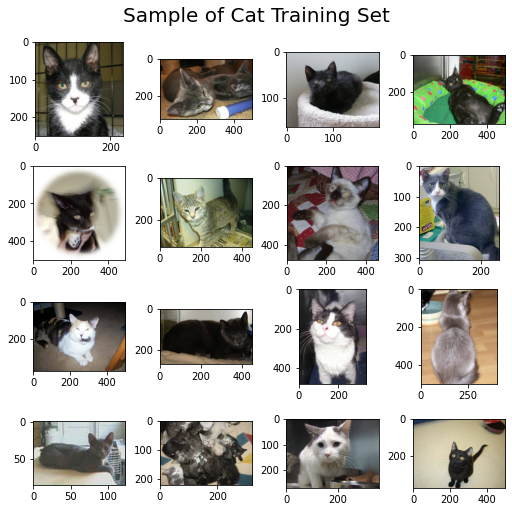

In [ ]:
## plot กราฟย่อย 
# โดยใส่กราฟได้ 4*4 และมีขนาดแต่ของละกราฟเป็น 7*7 --- constrained_layout=True เป็นการปรับขนาดโดยรวมของกราฟให้มีระยะห่างที่พอดี ไม่แคบเกินไป
fig,ax = plt.subplots(4,4,figsize=(7,7),constrained_layout=True)

# ใส่ชื่อกราฟตรงกลาง 
plt.suptitle('Sample of Cat Training Set', fontsize=20)

## ใช้ for loop เพื่อ plot ทีละรูป 
for i, row in cat_train_df.iterrows():
  # directory ของรูป
  digit = row['image'] 
  img = imread(cat_train_directory + digit) 
  
  # plot
  ax = ax.flatten()
  ax[i].imshow(img)
 
  # นับรอบ ให้ครบจำนวนกราฟย่อยที่กำหนดไปตอนต้น
  i = i + 1
  if i == 16:
    break

plt.show()
  

### 2.1.2 Dog Training set

In [ ]:
dog_train_directory = '/content/Cat_Dog_data/train/dog/'

dog_train_label = []

# list ชื่อไฟล์ที่อยู่ใน dog_train_directory 
dog_train_images = os.listdir(dog_train_directory)

# ใส่ label ให้กับข้อมูลโดยจำแนกตามชื่อไฟล์
for file in dog_train_images:
    if file.split('.')[0] == 'dog':
        dog_train_label.append('dog')

    else:
        dog_train_label.append('cat')

# สร้าง dataframe ของ dog_train_df
dog_train_df = pd.DataFrame({
    'image': dog_train_images,
    'label': dog_train_label
})

dog_train_df.sample(5)

,image,label
1706,dog.9357.jpg,dog
3664,dog.5812.jpg,dog
10120,dog.8799.jpg,dog
5321,dog.3087.jpg,dog
3923,dog.11565.jpg,dog


In [ ]:
print('Dog training set shape: ',dog_train_df.shape)

Dog Train set shape:  (11250, 2)


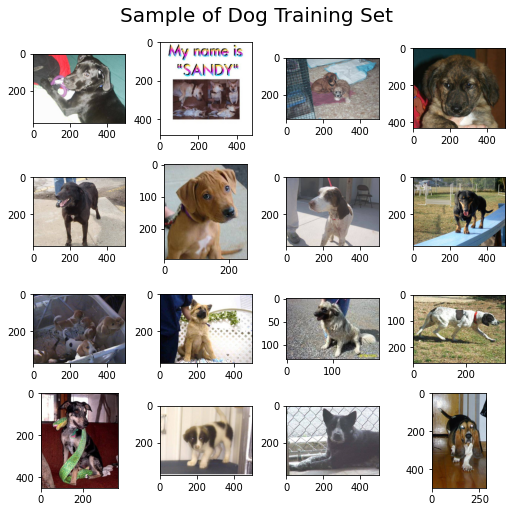

In [ ]:
## plot กราฟย่อย 
# โดยใส่กราฟได้ 4*4 และมีขนาดแต่ของละกราฟเป็น 7*7 --- constrained_layout=True เป็นการปรับขนาดโดยรวมของกราฟให้มีระยะห่างที่พอดี ไม่แคบเกินไป
fig,ax = plt.subplots(4,4,figsize=(7,7),constrained_layout=True)

# ใส่ชื่อกราฟตรงกลาง 
plt.suptitle('Sample of Dog Training Set', fontsize=20)

## ใช้ for loop เพื่อ plot ทีละรูป 
for i, row in dog_train_df.iterrows():
  # directory ของรูป
  digit = row['image'] 
  img = imread(dog_train_directory + digit) 
  
  # plot
  ax = ax.flatten()
  ax[i].imshow(img)
 
  # นับรอบ ให้ครบจำนวนกราฟย่อยที่กำหนดไปตอนต้น
  i = i + 1
  if i == 16:
    break

plt.show()

In [ ]:
print('Total Cat and Dog training set image: ',  int(cat_train_df['label'].value_counts()) +  int(dog_train_df['label'].value_counts()))

Total Cat and Dog training set image:  22500


### 2.2 Testing set

#### 2.2.1 Cat Testing set

In [ ]:
cat_test_directory = '/content/Cat_Dog_data/test/cat/'

cat_test_label = []

# list ชื่อไฟล์ที่อยู่ใน cat_test_directory 
cat_test_images = os.listdir(cat_test_directory)

# ใส่ label ให้กับข้อมูลโดยจำแนกตามชื่อไฟล์
for file in cat_test_images:
    if file.split('.')[0] == 'dog':
        cat_test_label.append('dog')

    else:
        cat_test_label.append('cat')

# สร้าง dataframe ของ cat_test_df
cat_test_df = pd.DataFrame({
    'image': cat_test_images,
    'label': cat_test_label
})

cat_test_df.sample(5)

,image,label
205,cat.3733.jpg,cat
964,cat.12291.jpg,cat
586,cat.1739.jpg,cat
242,cat.692.jpg,cat
1136,cat.10240.jpg,cat


In [ ]:
print('Cat testing set shape: ',cat_test_df.shape)

Cat testing set shape:  (1250, 2)


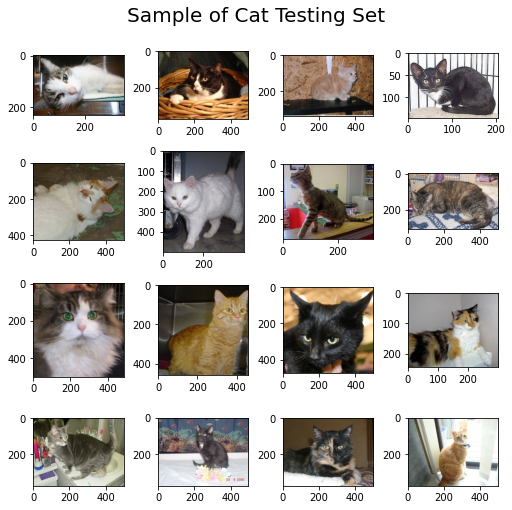

In [ ]:
## plot กราฟย่อย 
# โดยใส่กราฟได้ 4*4 และมีขนาดแต่ของละกราฟเป็น 7*7 --- constrained_layout=True เป็นการปรับขนาดโดยรวมของกราฟให้มีระยะห่างที่พอดี ไม่แคบเกินไป
fig,ax = plt.subplots(4,4,figsize=(7,7),constrained_layout=True)

# ใส่ชื่อกราฟตรงกลาง 
plt.suptitle('Sample of Cat Testing Set', fontsize=20)

## ใช้ for loop เพื่อ plot ทีละรูป 
for i, row in cat_test_df.iterrows():
  # destination ของรูป
  digit = row['image'] 
  img = imread(cat_test_directory + digit) 
  
  # plot
  ax = ax.flatten()
  ax[i].imshow(img)
 
  # นับรอบ ให้ครบจำนวนกราฟย่อยที่กำหนดไปตอนต้น
  i = i + 1
  if i == 16:
    break

plt.show()
  

#### 2.2.2 Dog Testing set

In [ ]:
dog_test_directory = '/content/Cat_Dog_data/test/dog/'

dog_test_label = []
# list ชื่อไฟล์ที่อยู่ใน dog_test_directory 
dog_test_images = os.listdir(dog_test_directory)

# ใส่ label ให้กับข้อมูลโดยจำแนกตามชื่อไฟล์
for file in dog_test_images:
    if file.split('.')[0] == 'dog':
        dog_test_label.append('dog')

    else:
        dog_test_label.append('cat')

# สร้าง dataframe ของ dog_test_df
dog_test_df = pd.DataFrame({
    'image': dog_test_images,
    'label': dog_test_label
})

dog_test_df.sample(5)

,image,label
674,dog.8686.jpg,dog
63,dog.9493.jpg,dog
984,dog.12247.jpg,dog
192,dog.860.jpg,dog
822,dog.7613.jpg,dog


In [ ]:
print('Dog testing set shape: ',dog_test_df.shape)

Dog testing set shape:  (1250, 2)


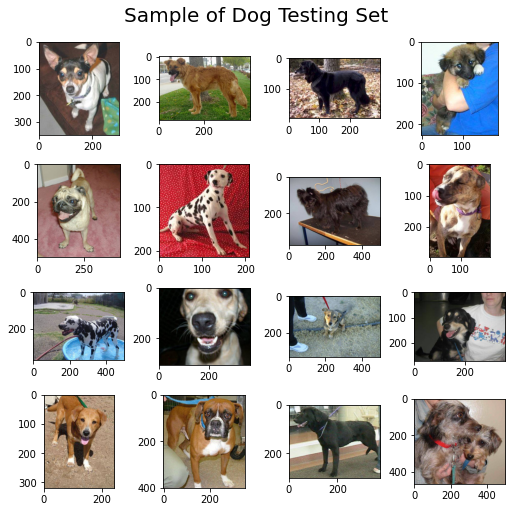

In [ ]:
## plot กราฟย่อย 
# โดยใส่กราฟได้ 4*4 และมีขนาดแต่ของละกราฟเป็น 7*7 --- constrained_layout=True เป็นการปรับขนาดโดยรวมของกราฟให้มีระยะห่างที่พอดี ไม่แคบเกินไป
fig,ax = plt.subplots(4,4,figsize=(7,7),constrained_layout=True)

# ใส่ชื่อกราฟตรงกลาง 
plt.suptitle('Sample of Dog Testing Set', fontsize=20)

## ใช้ for loop เพื่อ plot ทีละรูป 
for i, row in dog_test_df.iterrows():
  # destination ของรูป
  digit = row['image'] 
  img = imread(dog_test_directory + digit) 
  
  # plot
  ax = ax.flatten()
  ax[i].imshow(img)
 
  # นับรอบ ให้ครบจำนวนกราฟย่อยที่กำหนดไปตอนต้น
  i = i + 1
  if i == 16:
    break

plt.show()
  

In [ ]:
print('Total Cat and Dog testing set image: ',  int(cat_test_df['label'].value_counts()) +  int(dog_test_df['label'].value_counts()))

Total Cat and Dog testing set image:  2500


## **3. Preprocess data** 📑

In [5]:
# Data Augmentation
imggen = ImageDataGenerator(rescale=1./255,
                            shear_range=.2, 
                            rotation_range=.2, 
                            width_shift_range=.1,
                            height_shift_range=.1,
                            horizontal_flip = True)

# เตรียม train set และ test set
trainset = imggen.flow_from_directory('Cat_Dog_data/train',
                                      batch_size = 64,
                                      target_size = (256,256))
testset = imggen.flow_from_directory('Cat_Dog_data/test',
                                     batch_size = 64,
                                     target_size = (256,256))

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


จะได้ว่า Train set มี 22500  รูป และ Test set มี 2500  รูป โดยประกอบไปด้วย 2 class คือ cat และ dog

## **4. Build convolutional neural network 📦**

In [ ]:
img_width = 256
img_height = 256
img_channel = 3
img_shape = (img_width, img_height, img_channel)

### **model ที่ 1:** ลองปรับเอง

In [ ]:
mymodel = Sequential()
mymodel.add(layers.Conv2D(32,(3,3),
                          padding ='same', # เพิ่ม 0 เข้าไป
                          activation = 'elu',
                          kernel_initializer='he_uniform', # He uniform variance scaling initializer.
                          input_shape=img_shape  # กำหนดลักษณะข้อมูล input ที่เข้าไปใน layer นั้น ๆ 
                          ))
mymodel.add(layers.Conv2D(32,(3,3),
                          padding ='same',
                          activation = 'elu',
                          kernel_initializer='he_uniform',
                          input_shape=img_shape
                          ))
mymodel.add(layers.MaxPooling2D(2,2))
mymodel.add(BatchNormalization())
mymodel.add(layers.Conv2D(64,(3,3),
                          padding ='same',
                          activation = 'elu',
                          kernel_initializer='he_uniform',
                          input_shape=img_shape
                          ))
mymodel.add(layers.MaxPooling2D(2,2))
mymodel.add(layers.Conv2D(128,(3,3),
                          padding ='same',
                          activation = 'elu',
                          kernel_initializer='he_uniform',
                          input_shape=img_shape
                          ))
mymodel.add(layers.MaxPooling2D(2,2))
mymodel.add(BatchNormalization())
mymodel.add(layers.Dropout(0.25))

mymodel.add(layers.Flatten())
mymodel.add(layers.Dense(256, 
                         activation='elu',
                         kernel_initializer='he_uniform',))
mymodel.add(layers.Dropout(0.5))
mymodel.add(layers.Dense(2,activation='softmax',
                     kernel_initializer='he_uniform'
                    ))

mymodel.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
mymodel.save('baseline_mymodel.h5')
mymodel.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 conv2d_34 (Conv2D)          (None, 256, 256, 32)      9248      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 batch_normalization_16 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_35 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 64, 64, 64)      

### **model ที่ 2:** ลองปรับจาก model 1 ใหม่

model ที่ 2 เป็นการปรับจาก model 1 ใหม่ โดยสลับ BatchNormalization ให้อยู่ก่อน MaxPooling2D และปรับ Hyperparameters คือ เปลี่ยน strides จากเดิมที่เป็น (3,3) ให้เป็น (2,2) และกำหนด kernel size เป็น 3

In [ ]:
mymodel_ver2 = Sequential()
mymodel_ver2.add(layers.Conv2D(filters = 32,
                               strides = (2,2),
                               kernel_size=3,
                               padding ='same', # เพิ่ม 0 เข้าไป
                               activation = 'elu',
                               kernel_initializer='he_uniform', 
                               input_shape=img_shape  # กำหนดลักษณะข้อมูล input ที่เข้าไปใน layer นั้น ๆ 
                               ))

mymodel_ver2.add(layers.Conv2D(filters = 32,
                               strides = (2,2),
                               kernel_size=3,
                               padding ='same', # เพิ่ม 0 เข้าไป
                               activation = 'elu',
                               kernel_initializer='he_uniform', 
                               input_shape=img_shape  # กำหนดลักษณะข้อมูล input ที่เข้าไปใน layer นั้น ๆ 
                               ))

mymodel_ver2.add(BatchNormalization())
mymodel_ver2.add(layers.MaxPooling2D(2,2))
mymodel_ver2.add(layers.Dropout(0.25))
mymodel_ver2.add(layers.Conv2D(filters = 64,
                               strides = (2,2),
                               kernel_size=3,
                               padding ='same', # เพิ่ม 0 เข้าไป
                               activation = 'elu',
                               kernel_initializer='he_uniform', 
                               input_shape=img_shape  # กำหนดลักษณะข้อมูล input ที่เข้าไปใน layer นั้น ๆ 
                               ))
mymodel_ver2.add(BatchNormalization())
mymodel_ver2.add(layers.MaxPooling2D(2,2))
mymodel_ver2.add(layers.Conv2D(filters = 128,
                               strides = (2,2),
                               kernel_size=3,
                               padding ='same', # เพิ่ม 0 เข้าไป
                               activation = 'elu',
                               kernel_initializer='he_uniform', 
                               input_shape=img_shape  # กำหนดลักษณะข้อมูล input ที่เข้าไปใน layer นั้น ๆ 
                               ))
mymodel_ver2.add(layers.Dropout(0.25))

mymodel_ver2.add(layers.Flatten())
mymodel_ver2.add(layers.Dense(256, 
                         activation='elu',
                         kernel_initializer='he_uniform'))
mymodel_ver2.add(layers.Dropout(0.5))
mymodel_ver2.add(layers.Dense(2,activation='softmax',
                     kernel_initializer='he_uniform'
                    ))

mymodel_ver2.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['acc'])
mymodel_ver2.save('baseline_mymodel_ver2.h5')
mymodel_ver2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)       

### **model ที่ 3:**  Transfer Learning VGG16

In [ ]:
from keras.applications import vgg16

vgg16_model = vgg16.VGG16(include_top=False, 
                  weights='imagenet',
                  input_shape=(256,256,3))

vgg16_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

#### ปรับ vgg16 model โดยการเพิ่ม layer เพื่อให้เหมาะสมกับงาน classify dog หรือ cat ที่ทำ 

In [ ]:
for layer in vgg16_model.layers:
    layer.trainable = False

flat = Flatten()(vgg16_model.layers[-1].output)
class1 = Dense(units = 256, activation='elu')(flat)
class2 = Dense(units = 256, activation = 'elu')(class1)
output = Dense(units = 2, activation='softmax')(class2)

#### นำ layer ที่ต้องการเพิ่ม มารวมกับ vgg16 model  

In [ ]:
vgg16_model = Model(inputs=vgg16_model.inputs, outputs=output)
vgg16_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

In [ ]:
vgg16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

เมื่อ `vgg16_model.summary()` ดูแล้ว จะเห็นว่า layer ที่เพิ่ม ได้รวมกับ vgg16 model เรียบร้อยแล้ว ซึ่งพร้อมสำหรับการนำไป Train Model ต่อไปแล้ว

In [ ]:
vgg16_model.save('baseline_vgg16_model.h5') # save model ไว้ใช้ต่อได้

## **5. Train Model 📄**

### **model ที่ 1:** ลองปรับเอง

In [ ]:
history_mymodel = mymodel.fit(trainset,
                              batch_size=64,
                              epochs=20,
                              validation_data=testset)
mymodel.save('mymodel_itr20.h5') # save model ไว้ใช้ต่อได้


Epoch 1/20
352/352 [==============================] - 406s 1s/step - loss: 1.5753 - acc: 0.5507 - val_loss: 0.6317 - val_acc: 0.6344
Epoch 2/20
352/352 [==============================] - 396s 1s/step - loss: 0.7453 - acc: 0.5833 - val_loss: 0.5948 - val_acc: 0.6752
Epoch 3/20
352/352 [==============================] - 400s 1s/step - loss: 0.6314 - acc: 0.6415 - val_loss: 0.5539 - val_acc: 0.7096
Epoch 4/20
352/352 [==============================] - 396s 1s/step - loss: 0.5720 - acc: 0.6879 - val_loss: 0.5159 - val_acc: 0.7448
Epoch 5/20
352/352 [==============================] - 398s 1s/step - loss: 0.5363 - acc: 0.7238 - val_loss: 0.6089 - val_acc: 0.7112
Epoch 6/20
352/352 [==============================] - 397s 1s/step - loss: 0.5162 - acc: 0.7400 - val_loss: 0.4915 - val_acc: 0.7692
Epoch 7/20
352/352 [==============================] - 397s 1s/step - loss: 0.4907 - acc: 0.7586 - val_loss: 0.8327 - val_acc: 0.6740
Epoch 8/20
352/352 [==============================] - 397s 1s/step - 

Last train accuracy: 0.8732444643974304
Last validation accuracy: 0.6908000111579895


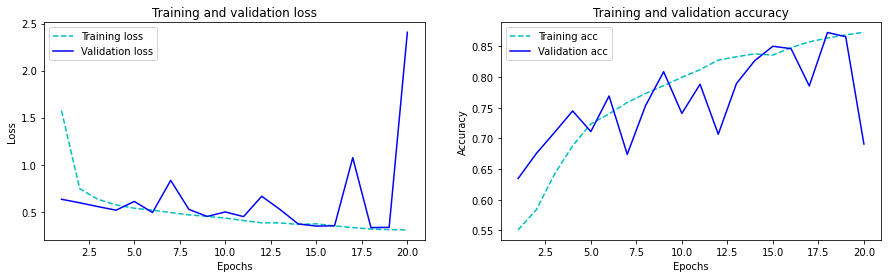

In [ ]:
show_result(history_mymodel)

- จะเห็นว่าครั้งล่าสุดที่ Trainig Model นี้ ก็คือ Epoch ที่ 20 มี validation accuracy ที่ลดลง และมี validation loss เพิ่มขึ้นอย่างมาก จึงคาดว่าเกิด overfitting ขึ้น เนื่องจากในตอน Trainig Model ไม่ได้มีการใส่คำสั่งที่หลีกเลี่ยงปัญหา overfitting เกิดขึ้น 

- การ Trainig Model ในครั้งถัดไปจึงต้องใส่คำสั่งหลีกเลี่ยงปัญหา overfitting เช่น EarlyStopping ไปด้วย 

In [ ]:
mymodel = models.load_model('baseline_mymodel.h5')  # Load model มาใช้ต่อ

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=2) # patience=2 หยุดตั้งแต่ 2 ครั้งแรกถ้าปรับแล้ว loss ไม่ดีขึ้นเลย
history_mymodel_earlystop = mymodel.fit(trainset,
                      batch_size=64,
                      epochs=20,
                      validation_data = testset,
                      callbacks=[early_stop]
                      )
mymodel.save('mymodel_itr20_earlystop.h5')

Epoch 1/20
352/352 [==============================] - 411s 1s/step - loss: 1.7016 - acc: 0.5350 - val_loss: 0.6469 - val_acc: 0.6168
Epoch 2/20
352/352 [==============================] - 402s 1s/step - loss: 0.7401 - acc: 0.5737 - val_loss: 0.6357 - val_acc: 0.6392
Epoch 3/20
352/352 [==============================] - 399s 1s/step - loss: 0.6406 - acc: 0.6269 - val_loss: 0.6011 - val_acc: 0.6452
Epoch 4/20
352/352 [==============================] - 398s 1s/step - loss: 0.5969 - acc: 0.6660 - val_loss: 0.6201 - val_acc: 0.6524
Epoch 5/20
352/352 [==============================] - 400s 1s/step - loss: 0.5752 - acc: 0.7002 - val_loss: 0.5454 - val_acc: 0.7348
Epoch 6/20
352/352 [==============================] - 399s 1s/step - loss: 0.5503 - acc: 0.7197 - val_loss: 0.4948 - val_acc: 0.7508
Epoch 7/20
352/352 [==============================] - 399s 1s/step - loss: 0.5340 - acc: 0.7383 - val_loss: 0.4951 - val_acc: 0.7536
Epoch 8/20
352/352 [==============================] - 400s 1s/step - 

Last train accuracy: 0.7825777530670166
Last validation accuracy: 0.770799994468689


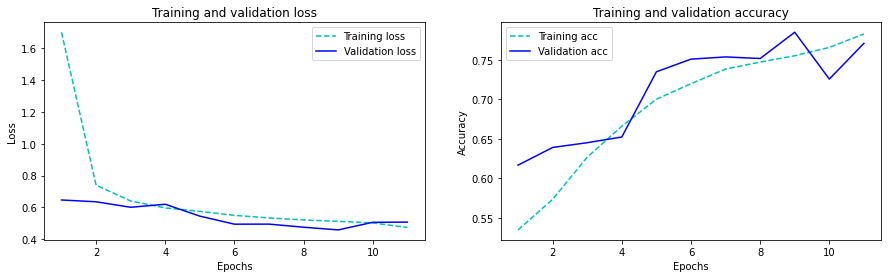

In [ ]:
show_result(history_mymodel_earlystop)

จากการ Train Model พบว่า ค่า accuracy ของทั้ง train และ validation อยู่ในค่าที่ใกล้เคียงกัน โดยในครั้งล่าสุดมี train accuracy: 0.78 และ validation accuracy: 0.77 ซึ่งนั่นแปลว่า model ที่ 1 นี้ ไม่เกิดการ overfitting หรือ underfitting ขึ้น แต่ค่า accuracy ของ model นี้ยังไม่เป็นที่น่าพอใจ จึงได้มีการลองปรับ batch_size ด้านล่างถัดไปดู

- ลองปรับ batch_size เป็น 128 ดู

In [ ]:
model_dir = '/content/drive/MyDrive/ColabNotebooks/model'
mymodel = models.load_model(model_dir+'/'+'baseline_mymodel.h5')  # Load model มาใช้ต่อ

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=2) # patience=2 หยุดตั้งแต่ 2 ครั้งแรกถ้าปรับแล้ว loss ไม่ดีขึ้นเลย
history_mymodel_earlystop = mymodel.fit(trainset,
                      batch_size=128,
                      epochs=20,
                      validation_data = testset,
                      callbacks=[early_stop]
                      )
mymodel.save('mymodel_itr20_earlystop_batch128.h5')

Epoch 1/20
352/352 [==============================] - 509s 1s/step - loss: 1.7878 - acc: 0.5408 - val_loss: 0.6268 - val_acc: 0.6364
Epoch 2/20
352/352 [==============================] - 479s 1s/step - loss: 0.7458 - acc: 0.5840 - val_loss: 0.7711 - val_acc: 0.6008
Epoch 3/20
352/352 [==============================] - 525s 1s/step - loss: 0.6452 - acc: 0.6294 - val_loss: 0.5635 - val_acc: 0.7196
Epoch 4/20
352/352 [==============================] - 493s 1s/step - loss: 0.6067 - acc: 0.6608 - val_loss: 0.5996 - val_acc: 0.6868
Epoch 5/20
352/352 [==============================] - 456s 1s/step - loss: 0.5742 - acc: 0.6935 - val_loss: 0.5383 - val_acc: 0.7056
Epoch 6/20
352/352 [==============================] - 471s 1s/step - loss: 0.5513 - acc: 0.7218 - val_loss: 0.5138 - val_acc: 0.7568
Epoch 7/20
352/352 [==============================] - 472s 1s/step - loss: 0.5405 - acc: 0.7361 - val_loss: 0.5644 - val_acc: 0.7208
Epoch 8/20
352/352 [==============================] - 464s 1s/step - 

Last train accuracy: 0.7659555673599243
Last validation accuracy: 0.722000002861023


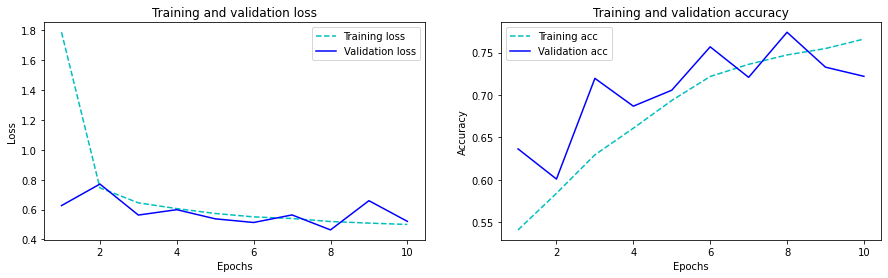

In [ ]:
show_result(history_mymodel_earlystop)

จากการลองปรับ batch_size เป็น 128 พบว่า ค่า accuracy ของ model นี้ ไม่ค่อยต่างไปจากในตอนแรกที่ตั้ง batch_size เป็น 64 เลย จึงต้องไปปรับ model ที่ 1 ใหม่ ซึ่งจะได้เป็น **model ที่ 2**

### **model ที่ 2:** ลองปรับจาก model 1 ใหม่

In [ ]:
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=2) 
history_mymodel_ver2_earlystop = mymodel_ver2.fit(trainset,
                      batch_size=128,
                      epochs=20,
                      validation_data = testset,
                      callbacks=[early_stop]
                      )

mymodel_ver2.save('mymodel_ver2_itr20_earlystop.h5')

Epoch 1/20
352/352 [==============================] - 446s 1s/step - loss: 0.7975 - acc: 0.6198 - val_loss: 0.8223 - val_acc: 0.6456
Epoch 2/20
352/352 [==============================] - 421s 1s/step - loss: 0.5781 - acc: 0.6938 - val_loss: 0.5660 - val_acc: 0.7112
Epoch 3/20
352/352 [==============================] - 416s 1s/step - loss: 0.5334 - acc: 0.7266 - val_loss: 0.5695 - val_acc: 0.7344
Epoch 4/20
352/352 [==============================] - 407s 1s/step - loss: 0.5046 - acc: 0.7498 - val_loss: 0.5121 - val_acc: 0.7408
Epoch 5/20
352/352 [==============================] - 420s 1s/step - loss: 0.4867 - acc: 0.7599 - val_loss: 0.4884 - val_acc: 0.7688
Epoch 6/20
352/352 [==============================] - 419s 1s/step - loss: 0.4664 - acc: 0.7789 - val_loss: 0.4779 - val_acc: 0.7732
Epoch 7/20
352/352 [==============================] - 429s 1s/step - loss: 0.4410 - acc: 0.7934 - val_loss: 0.4425 - val_acc: 0.7840
Epoch 8/20
352/352 [==============================] - 428s 1s/step - 

Last train accuracy: 0.855911135673523
Last validation accuracy: 0.8560000061988831


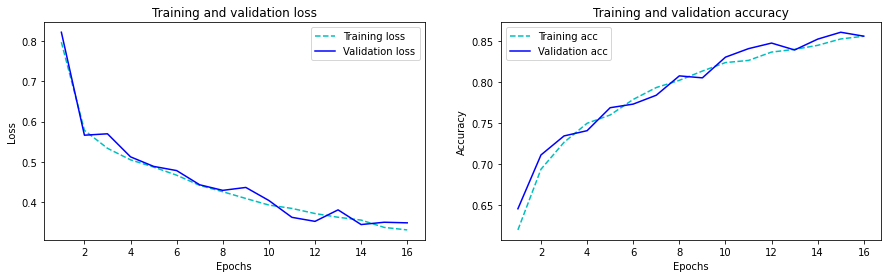

In [ ]:
show_result(history_mymodel_ver2_earlystop)

จากการ Train Model พบว่า ค่า accuracy ของทั้ง train และ validation อยู่ในค่าที่ใกล้เคียงกันมาก ๆ โดยในครั้งล่าสุดมี train accuracy: 0.8559 และ validation accuracy: 0.856 ซึ่งนั่นแปลว่า model ที่ 2: ลองปรับจาก model 1 ใหม่ นี้ ไม่เกิดการ overfitting หรือ underfitting ขึ้น และยังดีกว่า model ที่ 1

### **model ที่ 3:** Transfer Learning VGG16

In [ ]:
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=2) 
history_vgg16_model_earlystop = vgg16_model.fit(trainset,
                      batch_size=64,
                      epochs=20,
                      validation_data = testset,
                      callbacks=[early_stop]
                      )

vgg16_model.save('vgg16_model_itr20_earlystop.h5')

Epoch 1/20
352/352 [==============================] - 538s 1s/step - loss: 0.3810 - acc: 0.8779 - val_loss: 0.1856 - val_acc: 0.9268
Epoch 2/20
352/352 [==============================] - 513s 1s/step - loss: 0.1800 - acc: 0.9254 - val_loss: 0.1784 - val_acc: 0.9272
Epoch 3/20
352/352 [==============================] - 509s 1s/step - loss: 0.1682 - acc: 0.9300 - val_loss: 0.2192 - val_acc: 0.8956
Epoch 4/20
352/352 [==============================] - 514s 1s/step - loss: 0.1562 - acc: 0.9363 - val_loss: 0.1771 - val_acc: 0.9292
Epoch 5/20
352/352 [==============================] - 512s 1s/step - loss: 0.1570 - acc: 0.9355 - val_loss: 0.1852 - val_acc: 0.9236
Epoch 6/20
352/352 [==============================] - 511s 1s/step - loss: 0.1409 - acc: 0.9418 - val_loss: 0.2358 - val_acc: 0.9068


Last train accuracy: 0.941777765750885
Last validation accuracy: 0.9067999720573425


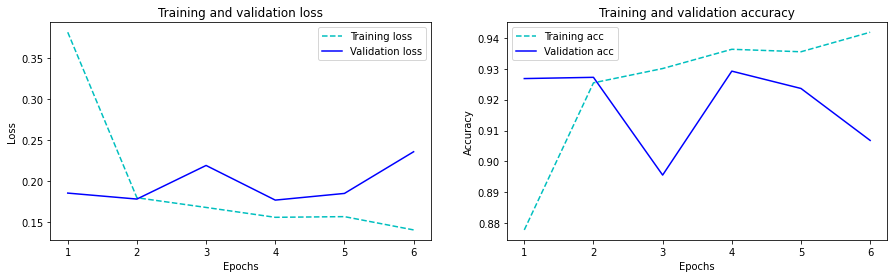

In [ ]:
show_result(history_vgg16_model_earlystop)

จากการ Train Model พบว่า ค่า accuracy ของทั้ง train และ validation อยู่ในค่าที่ใกล้เคียงกัน โดยในครั้งล่าสุดมี train accuracy: 0.94 และ validation accuracy: 0.90 ซึ่งนั่นแปลว่า model ที่ 3: Transfer Learning VGG16 นี้ ไม่เกิดการ overfitting หรือ underfitting ขึ้น

## **6. Evaluate Model ✅**

### **model ที่ 1:** ลองปรับเอง

In [ ]:
model_dir = '/content/drive/MyDrive/ColabNotebooks/model'
mymodel = models.load_model(model_dir+'/'+'mymodel_itr20_earlystop.h5') # Load model มาใช้ต่อ

In [ ]:
score = mymodel.evaluate(testset)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

40/40 [==============================] - 36s 899ms/step - loss: 0.4931 - acc: 0.7644
Test loss: 0.4931392967700958
Test accuracy: 0.7644000053405762


จะเห็นว่า model นี้ ค่อนข้างดีเพราะ Train Accuracy และ Test Accuracy ไม่ต่างกันมาก ซึ่งแปลว่าไม่เกิดการ overfitting หรือ underfitting ขึ้น แต่ทั้งนี้ทั้งนั้นค่า accuracy ของ model นี้ยังไม่เป็นที่น่าพอใจ

### **model ที่ 2:** ลองปรับจาก model 1 ใหม่

In [ ]:
model_dir = '/content/drive/MyDrive/ColabNotebooks/model'
mymodel_ver2 = models.load_model(model_dir+'/'+'mymodel_ver2_itr20_earlystop.h5') # Load model มาใช้ต่อ

In [ ]:
score = mymodel_ver2.evaluate(testset)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

40/40 [==============================] - 52s 1s/step - loss: 0.3607 - acc: 0.8516
Test loss: 0.3606698513031006
Test accuracy: 0.8515999913215637


จะเห็นว่า model นี้ ค่อนข้างดีเพราะ Train Accuracy และ Test Accuracy ไม่ต่างกันมาก ซึ่งแปลว่าไม่เกิดการ overfitting หรือ underfitting ขึ้น

### **model ที่ 3:** Transfer Learning VGG16

In [6]:
model_dir = '/content/drive/MyDrive/ColabNotebooks/model'
vgg16_model = models.load_model(model_dir+'/'+'vgg16_model_itr20_earlystop.h5') # Load model มาใช้ต่อ

In [10]:
score = vgg16_model.evaluate(testset)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

40/40 [==============================] - 42s 1s/step - loss: 0.2276 - acc: 0.9128
Test loss: 0.2276027798652649
Test accuracy: 0.9128000140190125


จะเห็นว่า model นี้ ค่อนข้างดีมากเพราะ Train Accuracy และ Test Accuracy ไม่ต่างกันมาก ซึ่งแปลว่าไม่เกิดการ overfitting หรือ underfitting ขึ้น

## **7. Conclusion 📝**

จากการลองสร้างทั้ง 3 model พบว่า **model ที่ 3: Transfer Learning VGG16 เป็น model ที่มี Train Accuracy และ Test Accuracy มากที่สุด โดยมีค่า Accuracy อยู่ที่ 0.9418 และ 0.9128 ตามลำดับ** โดยจะเห็นว่าค่า Accuracy ของทั้ง Train และ Test ไม่ต่างกันมาก ซึ่งแปลว่าไม่เกิดการ overfitting หรือ underfitting ขึ้น เนื่องจาก Train set และ Test set มีจำนวนข้อมูลของ Cat และ Dog ที่ balance กัน จึงสามารถใช้ค่า Accuracy ในการประเมิน model ได้



---



# **Challenge: ลองใส่หน้าตัวเองไปแล้วให้ model ทำนายดู 🔍**

In [ ]:
# directory ของรูป
image_directory = '/content/drive/MyDrive/ColabNotebooks/image'

In [ ]:
all_image = os.listdir(image_directory) # list ชื่อไฟล์ที่อยู่ใน image_directory
all_image

['ornrakorn.jpg', 'myrabbit.jpg', 'piya.jpg', 'mycat_1.jpg', 'mycat_2.jpg']

## 1. รูปของ Piyatida

In [ ]:
piya_image_file = all_image[2]

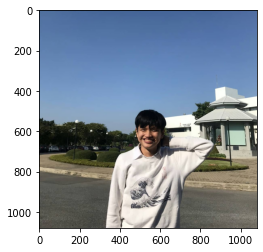

In [ ]:
# plot รูปที่ใช้
piya_image_dir = load_img(image_directory + '/' + piya_image_file)
plt.imshow(piya_image_dir)

In [ ]:
piya_image = image.load_img(image_directory +'/'+ piya_image_file, target_size=(256, 256))

piya_image_array = image.img_to_array(piya_image)

piya_image_batch = np.expand_dims(piya_image_array, axis = 0)

*วิธีด้านบนนี้ ดัดแปลงมาจาก https://towardsdatascience.com/how-to-predict-an-image-with-keras-ca97d9cd4817 นะคะ*

### **model ที่ 1:** ลองปรับเอง

In [ ]:
prediction = mymodel.predict(piya_image_batch)
prediction_result = np.argmax(prediction, axis=1)

if prediction[0][0] >= 0.5:
  print('Image file name:', piya_image_file,'\n',   
        '\nPrediction of this image: Cat',
        '\nwith prediction result', prediction_result)

else: 
  print('Image file name:', piya_image_file,'\n',  
        '\nPrediction of this image: Dog',
        '\nwith prediction result', prediction_result)

Image file name: piya.jpg 
 
Prediction of this image: Dog 
with prediction result [1]


### **model ที่ 2:** ลองปรับจาก model 1 ใหม่

In [ ]:
prediction = mymodel_ver2.predict(piya_image_batch)
prediction_result = np.argmax(prediction, axis=1)

if prediction[0][0] >= 0.5:
  print('Image file name:', piya_image_file,'\n',   
        '\nPrediction of this image: Cat',
        '\nwith prediction result', prediction_result)

else: 
  print('Image file name:', piya_image_file,'\n',  
        '\nPrediction of this image: Dog',
        '\nwith prediction result', prediction_result)

Image file name: piya.jpg 
 
Prediction of this image: Cat 
with prediction result [0]


### **model ที่ 3:** Transfer Learning VGG16

In [ ]:
prediction = vgg16_model.predict(piya_image_batch)
prediction_result = np.argmax(prediction, axis=1)

if prediction[0][0] >= 0.5:
  print('Image file name:', piya_image_file,'\n',  
        '\nPrediction of this image: Cat',
        '\nwith prediction result', prediction_result)

else: 
  print('Image file name:', piya_image_file,'\n',  
        '\nPrediction of this image: Dog',
        '\nwith prediction result', prediction_result)

Image file name: piya.jpg 
 
Prediction of this image: Dog 
with prediction result [1]


จากผลของการ prediction ของทั้ง 3 model จะเห็นว่า
1. Model ที่ 1 เละ 3 ทำนายรูปภาพออกมาว่าเป็น Dog 
2. Model ที่ 2 ทำนายรูปภาพออกมาว่าเป็น Cat



## 2. รูปของ Ornrakorn

In [ ]:
ornrakorn_image_file = all_image[0]

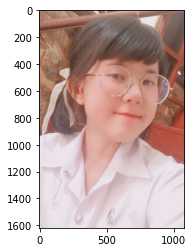

In [ ]:
# plot รูปที่ใช้
ornrakorn_image_dir = load_img(image_directory + '/' + ornrakorn_image_file)
plt.imshow(ornrakorn_image_dir)

In [ ]:
ornrakorn_image = image.load_img(image_directory +'/'+ ornrakorn_image_file, target_size=(256, 256))

ornrakorn_image_array = image.img_to_array(ornrakorn_image)

ornrakorn_image_batch = np.expand_dims(ornrakorn_image_array, axis = 0)

*วิธีด้านบนนี้ ดัดแปลงมาจาก https://towardsdatascience.com/how-to-predict-an-image-with-keras-ca97d9cd4817 นะคะ*

### **model ที่ 1:** ลองปรับเอง

In [ ]:
prediction = mymodel.predict(ornrakorn_image_batch)
prediction_result = np.argmax(prediction, axis=1)

if prediction[0][0] >= 0.5:
  print('Image file name:', ornrakorn_image_file,'\n',   
        '\nPrediction of this image: Cat',
        '\nwith prediction result', prediction_result)

else: 
  print('Image file name:', ornrakorn_image_file,'\n',  
        '\nPrediction of this image: Dog',
        '\nwith prediction result', prediction_result)

Image file name: ornrakorn.jpg 
 
Prediction of this image: Cat 
with prediction result [0]


### **model ที่ 2:** ลองปรับจาก model 1 ใหม่

In [ ]:
prediction = mymodel_ver2.predict(ornrakorn_image_batch)
prediction_result = np.argmax(prediction, axis=1)

if prediction[0][0] >= 0.5:
  print('Image file name:', ornrakorn_image_file,'\n',   
        '\nPrediction of this image: Cat',
        '\nwith prediction result', prediction_result)

else: 
  print('Image file name:', ornrakorn_image_file,'\n',  
        '\nPrediction of this image: Dog',
        '\nwith prediction result', prediction_result)

Image file name: ornrakorn.jpg 
 
Prediction of this image: Cat 
with prediction result [0]


### **model ที่ 3:** Transfer Learning VGG16

In [ ]:
prediction = vgg16_model.predict(ornrakorn_image_batch)
prediction_result = np.argmax(prediction, axis=1)

if prediction[0][0] >= 0.5:
  print('Image file name:', ornrakorn_image_file,'\n',  
        '\nPrediction of this image: Cat',
        '\nwith prediction result', prediction_result)

else: 
  print('Image file name:', ornrakorn_image_file,'\n',  
        '\nPrediction of this image: Dog',
        '\nwith prediction result', prediction_result)

Image file name: ornrakorn.jpg 
 
Prediction of this image: Dog 
with prediction result [1]


จากผลของการ prediction ของทั้ง 3 model จะเห็นว่า
1. Model ที่ 1 เละ 2  ทำนายรูปภาพออกมาว่าเป็น Cat 
2. Model ที่ 3 ทำนายรูปภาพออกมาว่าเป็น Dog




## 3. รูปกระต่ายของ Ornrakorn 
(อยากลองเฉย ๆ ค่ะ 555555)

In [ ]:
rabbit_image_file = all_image[1]

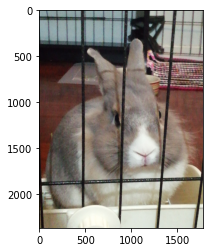

In [ ]:
# plot รูปที่ใช้
rabbit_image_dir = load_img(image_directory + '/' + rabbit_image_file)
plt.imshow(rabbit_image_dir)

In [ ]:
rabbit_image = image.load_img(image_directory +'/'+ rabbit_image_file, target_size=(256, 256))

rabbit_image_array = image.img_to_array(rabbit_image)

rabbit_image_batch = np.expand_dims(rabbit_image_array, axis = 0)


*วิธีด้านบนนี้ ดัดแปลงมาจาก https://towardsdatascience.com/how-to-predict-an-image-with-keras-ca97d9cd4817 นะคะ*

### **model ที่ 1:** ลองปรับเอง

In [ ]:
prediction = mymodel.predict(rabbit_image_batch)
prediction_result = np.argmax(prediction, axis=1)

if prediction[0][0] >= 0.5:
  print('Image file name:', rabbit_image_file,'\n',   
        '\nPrediction of this image: Cat',
        '\nwith prediction result', prediction_result)

else: 
  print('Image file name:', rabbit_image_file,'\n',  
        '\nPrediction of this image: Dog',
        '\nwith prediction result', prediction_result)

Image file name: myrabbit.jpg 
 
Prediction of this image: Dog 
with prediction result [1]


### **model ที่ 2:** ลองปรับจาก model 1 ใหม่

In [ ]:
prediction = mymodel_ver2.predict(rabbit_image_batch)
prediction_result = np.argmax(prediction, axis=1)

if prediction[0][0] >= 0.5:
  print('Image file name:', rabbit_image_file,'\n',   
        '\nPrediction of this image: Cat',
        '\nwith prediction result', prediction_result)

else: 
  print('Image file name:', rabbit_image_file,'\n',  
        '\nPrediction of this image: Dog',
        '\nwith prediction result', prediction_result)

Image file name: myrabbit.jpg 
 
Prediction of this image: Cat 
with prediction result [0]


### **model ที่ 3:** Transfer Learning VGG16

In [ ]:
prediction = vgg16_model.predict(rabbit_image_batch)
prediction_result = np.argmax(prediction, axis=1)

if prediction[0][0] >= 0.5:
  print('Image file name:', rabbit_image_file,'\n',  
        '\nPrediction of this image: Cat',
        '\nwith prediction result', prediction_result)

else: 
  print('Image file name:', rabbit_image_file,'\n',  
        '\nPrediction of this image: Dog',
        '\nwith prediction result', prediction_result)

Image file name: myrabbit.jpg 
 
Prediction of this image: Dog 
with prediction result [1]


จากผลของการ prediction ของทั้ง 3 model จะเห็นว่า 
1. Model ที่ 1 เละ 3  ทำนายรูปภาพออกมาว่าเป็น Dog 
2. Model ที่ 2 ทำนายรูปภาพออกมาว่าเป็น Cat

## 4. รูปแมวของ Ornrakorn 
(อยากลองเฉย ๆ ค่ะ 555555)

### 4.1 แบบเห็นหน้าแมวชัด ๆ

In [ ]:
cat_image_file = all_image[3]

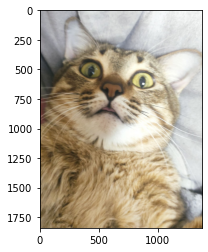

In [ ]:
# plot รูปที่ใช้
cat_image_dir = load_img(image_directory + '/' + cat_image_file)
plt.imshow(cat_image_dir)

In [ ]:
cat_image = image.load_img(image_directory +'/'+ cat_image_file, target_size=(256, 256))

cat_image_array = image.img_to_array(cat_image)

cat_image_batch = np.expand_dims(cat_image_array, axis = 0)

*วิธีด้านบนนี้ ดัดแปลงมาจาก https://towardsdatascience.com/how-to-predict-an-image-with-keras-ca97d9cd4817 นะคะ*

### **model ที่ 1:** ลองปรับเอง

In [ ]:
prediction = mymodel.predict(cat_image_batch)
prediction_result = np.argmax(prediction, axis=1)

if prediction[0][0] >= 0.5:
  print('Image file name:', cat_image_file,'\n',   
        '\nPrediction of this image: Cat',
        '\nwith prediction result', prediction_result)

else: 
  print('Image file name:', cat_image_file,'\n',  
        '\nPrediction of this image: Dog',
        '\nwith prediction result', prediction_result)

Image file name: mycat_1.jpg 
 
Prediction of this image: Cat 
with prediction result [0]


### **model ที่ 2:** ลองปรับจาก model 1 ใหม่

In [ ]:
prediction = mymodel_ver2.predict(cat_image_batch)
prediction_result = np.argmax(prediction, axis=1)

if prediction[0][0] >= 0.5:
  print('Image file name:', cat_image_file,'\n',   
        '\nPrediction of this image: Cat',
        '\nwith prediction result', prediction_result)

else: 
  print('Image file name:', cat_image_file,'\n',  
        '\nPrediction of this image: Dog',
        '\nwith prediction result', prediction_result)

Image file name: mycat_1.jpg 
 
Prediction of this image: Cat 
with prediction result [0]


### **model ที่ 3:** Transfer Learning VGG16

In [ ]:
prediction = vgg16_model.predict(cat_image_batch)
prediction_result = np.argmax(prediction, axis=1)

if prediction[0][0] >= 0.5:
  print('Image file name:', cat_image_file,'\n',  
        '\nPrediction of this image: Cat',
        '\nwith prediction result', prediction_result)

else: 
  print('Image file name:', cat_image_file,'\n',  
        '\nPrediction of this image: Dog',
        '\nwith prediction result', prediction_result)

Image file name: mycat_1.jpg 
 
Prediction of this image: Cat 
with prediction result [0]


จากผลของการ prediction จะเห็นว่าทั้ง 3 model ทำนายรูปภาพออกมาว่าเป็น Cat ซึ่งถูกต้อง


### 4.2 แบบเห็นหน้าแมวไม่ชัด

In [ ]:
cat_image_file2 = all_image[4]

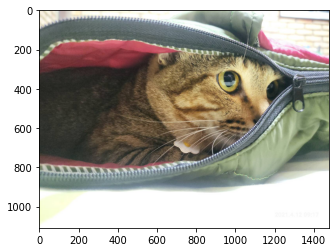

In [ ]:
# plot รูปที่ใช้
cat_image_dir2 = load_img(image_directory + '/' + cat_image_file2)
plt.imshow(cat_image_dir2)

In [ ]:
cat_image2 = image.load_img(image_directory +'/'+ cat_image_file2, target_size=(256, 256))

cat_image_array2 = image.img_to_array(cat_image2)

cat_image_batch2 = np.expand_dims(cat_image_array2, axis = 0)

*วิธีด้านบนนี้ ดัดแปลงมาจาก https://towardsdatascience.com/how-to-predict-an-image-with-keras-ca97d9cd4817 นะคะ*

### **model ที่ 1:** ลองปรับเอง

In [ ]:
prediction = mymodel.predict(cat_image_batch2)
prediction_result = np.argmax(prediction, axis=1)

if prediction[0][0] >= 0.5:
  print('Image file name:', cat_image_file2,'\n',   
        '\nPrediction of this image: Cat',
        '\nwith prediction result', prediction_result)

else: 
  print('Image file name:', cat_image_file2,'\n',  
        '\nPrediction of this image: Dog',
        '\nwith prediction result', prediction_result)

Image file name: mycat_2.jpg 
 
Prediction of this image: Dog 
with prediction result [1]


### **model ที่ 2:** ลองปรับจาก model 1 ใหม่

In [ ]:
prediction = mymodel_ver2.predict(cat_image_batch2)
prediction_result = np.argmax(prediction, axis=1)

if prediction[0][0] >= 0.5:
  print('Image file name:', cat_image_file2,'\n',   
        '\nPrediction of this image: Cat',
        '\nwith prediction result', prediction_result)

else: 
  print('Image file name:', cat_image_file2,'\n',  
        '\nPrediction of this image: Dog',
        '\nwith prediction result', prediction_result)

Image file name: mycat_2.jpg 
 
Prediction of this image: Cat 
with prediction result [0]


### **model ที่ 3:** Transfer Learning VGG16

In [ ]:
prediction = vgg16_model.predict(cat_image_batch2)
prediction_result = np.argmax(prediction, axis=1)

if prediction[0][0] >= 0.5:
  print('Image file name:', cat_image_file2,'\n',  
        '\nPrediction of this image: Cat',
        '\nwith prediction result', prediction_result)

else: 
  print('Image file name:', cat_image_file2,'\n',  
        '\nPrediction of this image: Dog',
        '\nwith prediction result', prediction_result)

Image file name: mycat_2.jpg 
 
Prediction of this image: Cat 
with prediction result [0]


จากผลของการ prediction ของทั้ง 3 model จะเห็นว่า
1. Model ที่ 2 เละ 3 ทำนายรูปภาพออกมาว่าเป็น Cat ซึ่งทำนายถูกต้อง
2. Model ที่ 1 ทำนายรูปภาพออกมาว่าเป็น Dog ซึ่งทำนายผิด

โดยจะเห็นว่า Model ที่ 1 ทำนายรูปภาพ 4.1 แบบเห็นหน้าแมวชัด ๆ ถูกต้อง แต่ทำนายรูปภาพ 4.2 แบบเห็นหน้าแมวไม่ชัด ไม่ถูกต้อง น่าจะเป็นเพราะ Model ที่ 1 ยังไม่มีประสิทธิภาพเพียงพอ โดยอาจมาจากโครงสร้างของ Model และการปรับ Hyperparameters ต่าง ๆ ที่ยังไม่ดีพอ เมื่อเทียบกับ model ที่ 2 และ 3

---